# Лабораторная работа 1

# Ершов Михаил Владимирович 6233

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

3) Построение softmax-классификатора

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

ВЫБРАН ВАРИАНТ 1

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [ ]:
# Импортируем необходимые библиотеки

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import sklearn
from sklearn.metrics import accuracy_score
import keras

import time
from datetime import datetime

import tensorflow as tf

#Импортируем датасеты
from keras.datasets import cifar10

from scipy import spatial

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### 1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST 
sklearn.datasets import load_digits
digits = load_digits()

In [ ]:
# После импорта датасетов необходимо определить их в соответствующие переменные
cifar = cifar10.load_data()

170498071/170498071 [==============================] - 5s 0us/step


Разделим выборку на тренировочную и тестовую, посмотрим её размер

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar


print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


### 1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



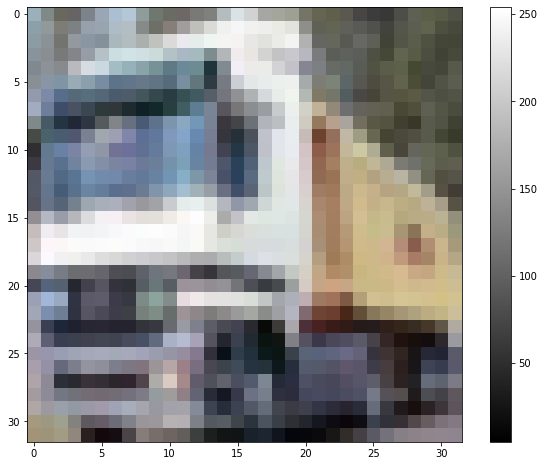

In [ ]:
# посмотрим, как выглядят изображения
plt.figure()
plt.imshow(x_train[1])
plt.colorbar()
plt.grid(False)

In [ ]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

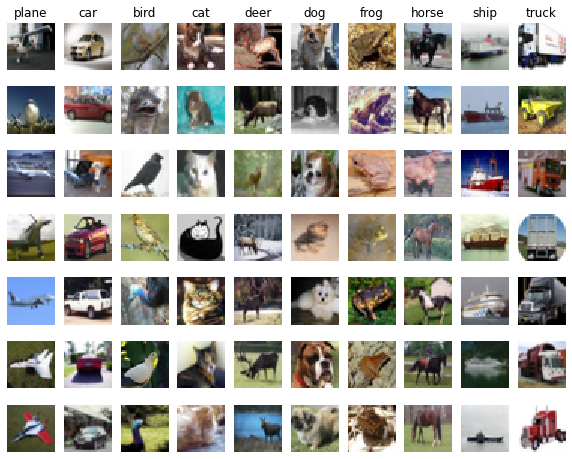

In [ ]:
mapping_labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
n_classes = len(mapping_labels)
n_samples = 7

for class_index, class_name in enumerate(mapping_labels):
    class_indexes = np.random.choice(np.flatnonzero(y_train == class_index), n_samples, replace=False)
    for i, idx in enumerate(class_indexes):
        plt_idx = i * n_classes + class_index + 1
        plt.subplot(n_samples, n_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(class_name)
plt.show()

### 1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив. 

In [ ]:
# сократим объем выборки (слишком долго все считается)
num_training = 5000
mask = list(range(num_training))
x_train_mask = x_train[mask]
y_train_new = y_train[mask]

num_test = 500
mask = list(range(num_test))
x_test_mask = x_test[mask]
y_test_new = y_test[mask]



In [ ]:
# преобразуем изображения в одномерный массив.
x_train_new = np.reshape(x_train_mask, (x_train_mask.shape[0], -1))
x_test_new = np.reshape(x_test_mask, (x_test_mask.shape[0], -1))
print(x_train_new.shape, x_test_new.shape, y_train_new.shape, y_test_new.shape)

(5000, 3072) (500, 3072) (5000, 1) (500, 1)


### 1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке. 

#### Добавим скрипт KNearestNeighbor в данный файл

In [ ]:
import numpy as np
from tqdm import tqdm

class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """

    def __init__(self):
        pass

    def train(self, X, y):
        """
        Train the classifier. For k-nearest neighbors this is just
        memorizing the training data.
        Inputs:
        - X: A numpy array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1, num_loops=0):
        """
        Predict labels for test data using this classifier.
        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data consisting
             of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.
        - num_loops: Determines which implementation to use to compute distances
          between training points and testing points.
        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
            dists = self.compute_distances_two_loops(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)

        return self.predict_labels(dists, k=k)

    def compute_distances_two_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a nested loop over both the training data and the
        test data.
        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.
        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          is the Euclidean distance between the ith test point and the jth training
          point.
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            for j in range(num_train):
                #####################################################################
                # TODO:                                                             #
                # Compute the l2 distance between the ith test point and the jth    #
                # training point, and store the result in dists[i, j]. You should   #
                # not use a loop over dimension, nor use np.linalg.norm().          #
                #####################################################################
                # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

                dists[i][j] = np.sqrt(np.sum((X[i] - self.X_train[j]) ** 2))
                
                #for j in range(num_train):
                 #   dists[i, j] = np.sqrt(np.sum(np.square(X[i, :] - self.X_train[j, :])))

                # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def compute_distances_one_loop(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a single loop over the test data.
        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            #######################################################################
            # TODO:                                                               #
            # Compute the l2 distance between the ith test point and all training #
            # points, and store the result in dists[i, :].                        #
            # Do not use np.linalg.norm().                                        #
            #######################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            #dists[i] = np.sqrt(np.sum((self.X_train - X[i]) ** 2, axis=1))
            dists[i, :] = np.sqrt(np.sum(np.square(self.X_train - X[i, :]), axis = 1))
            

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def compute_distances_no_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using no explicit loops.
        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        #########################################################################
        # TODO:                                                                 #
        # Compute the l2 distance between all test points and all training      #
        # points without using any explicit loops, and store the result in      #
        # dists.                                                                #
        #                                                                       #
        # You should implement this function using only basic array operations; #
        # in particular you should not use functions from scipy,                #
        # nor use np.linalg.norm().                                             #
        #                                                                       #
        # HINT: Try to formulate the l2 distance using matrix multiplication    #
        #       and two broadcast sums.                                         #
        #########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        #s1 = np.sum(X ** 2, axis=1)
        #s2 = np.sum(self.X_train ** 2, axis=1)
        #s = s1.reshape((num_test, 1)) + s2 - 2 * X.dot(self.X_train.T)
        #dists = np.sqrt(s)
        
        dists = np.sqrt(-2 * np.dot(X, self.X_train.T) +
                    np.sum(np.square(self.X_train), axis=1) +
                    np.sum(np.square(X), axis=1)[:, np.newaxis])
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.
        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.
        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            # A list of length k storing the labels of the k nearest neighbors to
            # the ith test point.
            closest_y = []
            #########################################################################
            # TODO:                                                                 #
            # Use the distance matrix to find the k nearest neighbors of the ith    #
            # testing point, and use self.y_train to find the labels of these       #
            # neighbors. Store these labels in closest_y.                           #
            # Hint: Look up the function numpy.argsort.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            knn_ix = dists[i].argsort()[:k]
            closest_y = self.y_train[knn_ix]
            
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            #########################################################################
            # TODO:                                                                 #
            # Now that you have found the labels of the k nearest neighbors, you    #
            # need to find the most common label in the list closest_y of labels.   #
            # Store this label in y_pred[i]. Break ties by choosing the smaller     #
            # label.                                                                #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            
            values, counts = np.unique(closest_y, return_counts=True)
            y_pred[i] = values[counts == counts.max()].min()

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return y_pred


#### Добавление завершено, выполним обучение

In [ ]:
classifier_KNN = KNearestNeighbor()
classifier_KNN.train(x_train_new, y_train_new)

### 1.5 Выполните классификацию на тестовой выборке

In [ ]:
# пробуем разные алгоритмы, замеряем время выполнения

start_time2 = datetime.now()

dists_two_loops = classifier_KNN.compute_distances_two_loops(x_test_new)

time_two_loops = datetime.now() - start_time2

print(dists_two_loops.shape)

(500, 5000)


In [ ]:
start_time3 = datetime.now()

dists_one_loop = classifier_KNN.compute_distances_one_loop(x_test_new)

time_one_loop = datetime.now() - start_time3

print(dists_one_loop.shape)

(500, 5000)


In [ ]:
start_time4 = datetime.now()

dists_no_loops = classifier_KNN.compute_distances_no_loops(x_test_new)

time_no_loops = datetime.now() - start_time4

print(dists_no_loops.shape)

(500, 5000)


### 1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки. 


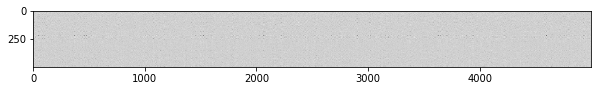

In [ ]:
plt.imshow(dists_two_loops, interpolation = 'none')


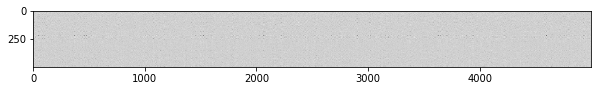

In [ ]:
plt.imshow(dists_one_loop, interpolation = 'none')
plt.show()

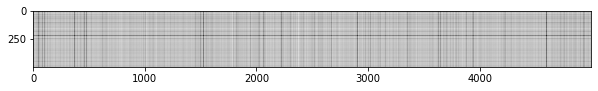

In [ ]:
plt.imshow(dists_no_loops, interpolation = 'none')

### 1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [ ]:
def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.sum(y_pred == y_true) / np.sum(y_true.shape)

In [ ]:
knn_y_test_predicts = classifier_KNN.predict_labels(dists_two_loops)
print(f"Accuracy: {accuracy(knn_y_test_predicts, y_test_new)}")

Accuracy: 52.076


In [ ]:
y_test_new_array = []
for i in range (y_test_new.shape[0]):
    y_test_new_array.append(np.float64(y_test_new[i][0]))
y_test_new_array = np.array(y_test_new_array)

### 1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

In [ ]:
neighbors = [1, 2, 3, 4, 5, 8, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50]

accur = {1:0, 2:0, 3:0, 4:0, 5:0, 8:0, 10:0, 12:0, 15:0, 20:0, 25:0, 30:0, 35:0, 40:0, 45:0, 50:0}
knn_accuracy = []


for k in neighbors:
    knn_model = KNearestNeighbor()
    knn_model.train(x_train_new, y_train_new)
    dists = knn_model.compute_distances_no_loops(x_test_new)
    y_test_pred_knn = knn_model.predict_labels(dists, k = k)
    knn_accuracy.append(np.sum(y_test_pred_knn == knn_y_test_predicts) / num_test)
    accur[k] = np.sum(y_test_pred_knn == knn_y_test_predicts) / num_test

### 1.9 Выберите лучшее значение параметра k на основе кросс-валидации.


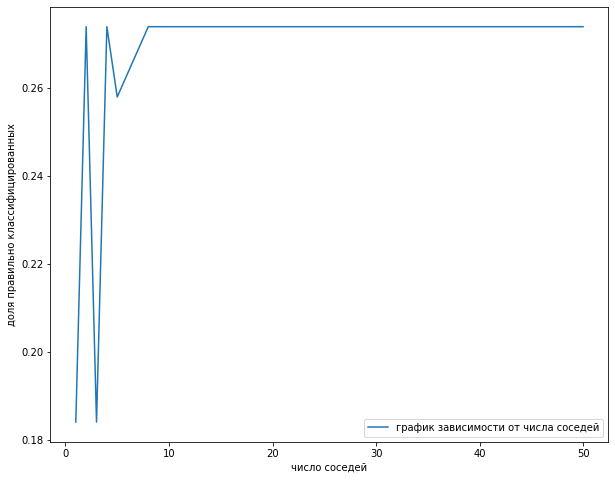

In [ ]:
# график зависимости

plt.plot(neighbors, knn_accuracy, label = 'график зависимости от числа соседей')


plt.legend()
plt.xlabel('число соседей')
plt.ylabel('доля правильно классифицированных')
plt.show()

In [ ]:
best_neighbors = max(accur, key = accur.get)
print(best_neighbors)

2


### 1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [ ]:
model_KNN_best = KNearestNeighbor()
model_KNN_best.train(x_train_new, y_train_new)

In [ ]:
y_test_pred_two_loops = model_KNN_best.predict_labels(dists_two_loops, k = 5)


print ('доля правильно классифицированных:', np.sum(y_test_pred_two_loops == y_test_new_array) / num_test)

доля правильно классифицированных: 0.2


### 1.11 Сделайте выводы по результатам 1 части задания.

Точность классификатора k-ближайших соседей зависит от количества соседей. С их увеличением растёт точность, но и время обучения. Плюс, В случае с большим количеством соседей растёт риск переобучения.

## 2.  Классификация данных методом опорных векторов (SVM)

### 2.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [ ]:
# Снова определим тренировочную и тестовую выборки
(x_train, y_train), (x_test, y_test) = cifar

In [ ]:
num_training = 49000
num_validation = 1000
num_test = 8000
num_dev = 1000

mask = range(num_training, num_training + num_validation)
x_val = x_train[mask]
y_val = y_train[mask]

mask = range(num_training)
x_train = x_train[mask]
y_train = y_train[mask]


mask = np.random.choice(num_training, num_dev, replace = False)
x_dev = x_train[mask]
y_dev = y_train[mask]

mask = range(num_test)
x_test = x_test[mask]
y_test = y_test[mask]

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
x_val = np.reshape(x_val, (x_val.shape[0], -1))
x_dev = np.reshape(x_dev, (x_dev.shape[0], -1))


print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)
print (x_val.shape, y_val.shape)
print (x_dev.shape, y_dev.shape)

(49000, 3072) (49000, 1)
(8000, 3072) (8000, 1)
(1000, 3072) (1000, 1)
(1000, 3072) (1000, 1)


### 2.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


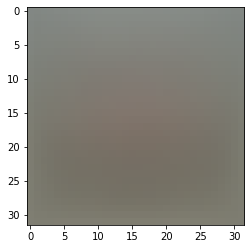

In [ ]:
mean_image = np.mean(x_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize = (4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()

### 2.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву дынных и заполните ее 1.

In [ ]:
x_train = x_train - mean_image
x_val = x_val -mean_image
x_test = x_test - mean_image
x_dev = x_dev - mean_image

In [ ]:
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])
x_val = np.hstack([x_val, np.ones((x_val.shape[0], 1))])
x_dev = np.hstack([x_dev, np.ones((x_dev.shape[0], 1))])


print(x_train.shape, x_test.shape, x_val.shape, x_dev.shape)

(49000, 3073) (8000, 3073) (1000, 3073) (1000, 3073)


### 2.4 Реализуйте loss-функции в scripts/classifiers/linear_svm.py



In [ ]:
W = np.random.randn(3073, 10) * 0.0001 

### Добавим скрипт linear_svm

In [ ]:
import numpy as np
from random import shuffle


def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.
    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength
    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    dW = np.zeros(W.shape) # initialize the gradient as zero

    # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    
    loss = 0.0     
    for i in range(1, num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1 # note delta = 1
            if margin > 0:
                loss = loss + margin
                

    # Right now the loss is a sum over all training examples, but we want it
    # to be an average instead so we divide by num_train.
    loss = loss / num_train

    # Add regularization to the loss.
    loss = loss + 0.5*reg * np.sum(W * W)

    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather than first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    dW = dW + W * reg

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    return loss, dW



def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.
    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    scores = np.dot(X,W)

    num_train = X.shape[0]
    rows = range(num_train)
    correct_class_score = scores[rows[1],y]

    margins = np.maximum(0,scores-np.reshape(correct_class_score,[num_train,1])+1)
    margins[rows[1],y] = 0
    loss = np.sum(margins)
    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)
  
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    margins[margins > 0] = 1.0
    row_sum = np.sum(margins, axis=1)                  
    margins[np.arange(num_train), y] = -row_sum        
    dW = dW + np.dot(X.T, margins)/num_train + reg * W  

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW

#### Скрипт добавлен

In [ ]:
loss, grad = svm_loss_naive(W, x_dev, y_dev, 0.00001)
print('loss: %f' % (loss, ))

loss: 9.186494


### 2.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

#### Добавляем файл gradient_check

In [ ]:
from __future__ import print_function

import numpy as np
from random import randrange


def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x)  # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h)  # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext()  # step to next dimension

    return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad


def eval_numerical_gradient_blobs(f, inputs, output, h=1e-5):
    """
    Compute numeric gradients for a function that operates on input
    and output blobs.
    We assume that f accepts several input blobs as arguments, followed by a
    blob where outputs will be written. For example, f might be called like:
    f(x, w, out)
    where x and w are input Blobs, and the result of f will be written to out.
    Inputs:
    - f: function
    - inputs: tuple of input blobs
    - output: output blob
    - h: step size
    """
    numeric_diffs = []
    for input_blob in inputs:
        diff = np.zeros_like(input_blob.diffs)
        it = np.nditer(input_blob.vals, flags=['multi_index'],
                       op_flags=['readwrite'])
        while not it.finished:
            idx = it.multi_index
            orig = input_blob.vals[idx]

            input_blob.vals[idx] = orig + h
            f(*(inputs + (output,)))
            pos = np.copy(output.vals)
            input_blob.vals[idx] = orig - h
            f(*(inputs + (output,)))
            neg = np.copy(output.vals)
            input_blob.vals[idx] = orig

            diff[idx] = np.sum((pos - neg) * output.diffs) / (2.0 * h)

            it.iternext()
        numeric_diffs.append(diff)
    return numeric_diffs


def eval_numerical_gradient_net(net, inputs, output, h=1e-5):
    return eval_numerical_gradient_blobs(lambda *args: net.forward(),
                                         inputs, output, h=h)


def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evaluate f(x + h)
        x[ix] = oldval - h  # increment by h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = (abs(grad_numerical - grad_analytic) /
                     (abs(grad_numerical) + abs(grad_analytic)))
        print('numerical: %f analytic: %f, relative error: %e'
              % (grad_numerical, grad_analytic, rel_error))

#### Скрипт добавлен

In [ ]:

loss, grad = svm_loss_naive(W, x_dev, y_dev, 0.0)

f = lambda w: svm_loss_naive(w, x_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)


loss, grad = svm_loss_naive(W, x_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, x_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -28.156962 analytic: 0.000000, relative error: 1.000000e+00
numerical: -46.834060 analytic: 0.000000, relative error: 1.000000e+00
numerical: 5.943789 analytic: 0.000000, relative error: 1.000000e+00
numerical: -31.533134 analytic: 0.000000, relative error: 1.000000e+00
numerical: -12.539513 analytic: 0.000000, relative error: 1.000000e+00
numerical: -4.823398 analytic: 0.000000, relative error: 1.000000e+00
numerical: -0.818511 analytic: 0.000000, relative error: 1.000000e+00
numerical: 0.945761 analytic: 0.000000, relative error: 1.000000e+00
numerical: -13.566064 analytic: 0.000000, relative error: 1.000000e+00
numerical: -5.440572 analytic: 0.000000, relative error: 1.000000e+00
numerical: 11.934028 analytic: -0.000710, relative error: 1.000000e+00
numerical: -44.855278 analytic: -0.008286, relative error: 9.996306e-01
numerical: 17.716681 analytic: -0.000791, relative error: 1.000000e+00
numerical: -5.910162 analytic: -0.002774, relative error: 9.990616e-01
numerical: -

### 2.6 Сравните svm_loss_naive и svm_loss_vectorized реализации

In [ ]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, x_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, x_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.149085s
Vectorized loss and gradient: computed in 0.047762s
difference: 3919.306509


### 2.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

#### Добавляем скрипт linear_classifier

In [ ]:

from __future__ import annotations

from typing import TYPE_CHECKING

import numpy as np
from tqdm import tqdm

if TYPE_CHECKING:
    from typing import List


class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(
            self,
            X: np.ndarray,
            y: np.ndarray,
            learning_rate: float = 1e-3,
            reg: float = 1e-5,
            num_iters: int = 100,
            batch_size: int = 200,
            verbose: bool = False,
    ) -> List[float]:
        """
        Train this linear classifier using stochastic gradient descent.
        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.
        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1  # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in tqdm(range(num_iters)):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (batch_size, dim)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            sample_index = np.random.choice(num_train, batch_size)
            X_batch = X[sample_index]
            y_batch = y[sample_index]

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            self.W -= grad * learning_rate

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            if verbose and it % 100 == 0:
                print("iteration %d / %d: loss %f" % (it, num_iters, loss))

        return loss_history

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.
        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[1])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        y_pred = np.argmax(X.dot(self.W), axis=1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.
        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.
        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

#### Добавлено

In [ ]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(x_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

  0%|          | 0/1500 [00:00<?, ?it/s]

iteration 0 / 1500: loss 430.187917


  8%|▊         | 121/1500 [00:00<00:10, 131.31it/s]

iteration 100 / 1500: loss 667.671515


 15%|█▌        | 225/1500 [00:01<00:09, 132.95it/s]

iteration 200 / 1500: loss 1110.775439


 22%|██▏       | 326/1500 [00:02<00:08, 137.58it/s]

iteration 300 / 1500: loss 2320.759178


 28%|██▊       | 427/1500 [00:03<00:07, 137.76it/s]

iteration 400 / 1500: loss 5920.404884


 34%|███▍      | 514/1500 [00:03<00:07, 135.75it/s]

iteration 500 / 1500: loss 3026.849675


 41%|████▏     | 619/1500 [00:04<00:06, 137.29it/s]

iteration 600 / 1500: loss 5285.600029


 48%|████▊     | 726/1500 [00:05<00:05, 143.17it/s]

iteration 700 / 1500: loss 5696.136094


 55%|█████▌    | 827/1500 [00:06<00:05, 132.77it/s]

iteration 800 / 1500: loss 5861.423908


 62%|██████▏   | 927/1500 [00:06<00:04, 131.30it/s]

iteration 900 / 1500: loss 5623.491569


 69%|██████▊   | 1028/1500 [00:07<00:03, 139.62it/s]

iteration 1000 / 1500: loss 6185.645464


 74%|███████▍  | 1117/1500 [00:08<00:02, 135.82it/s]

iteration 1100 / 1500: loss 11477.845168


 82%|████████▏ | 1223/1500 [00:09<00:02, 136.81it/s]

iteration 1200 / 1500: loss 11098.015101


 88%|████████▊ | 1323/1500 [00:09<00:01, 134.12it/s]

iteration 1300 / 1500: loss 9670.589175


 95%|█████████▍| 1424/1500 [00:10<00:00, 133.69it/s]

iteration 1400 / 1500: loss 7922.022927


100%|██████████| 1500/1500 [00:11<00:00, 134.84it/s]

That took 11.138537s


In [ ]:
y_train_pred = svm.predict(x_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(x_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.100064
validation accuracy: 0.096641


### 2.8 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [ ]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

In [ ]:
results = {}
best_val = -1   
best_svm = None

In [ ]:
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(x_train, y_train, lr, reg, num_iters=2000, verbose=False)
        y_train_pred = svm.predict(x_train)
        y_val_pred = svm.predict(x_val)
        training_accuracies = np.mean(y_train == y_train_pred)
        validation_accuracies = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (training_accuracies, validation_accuracies)
        if validation_accuracies > best_val:
            
            best_val = validation_accuracies

 43%|████▎     | 858/2000 [00:06<00:07, 144.70it/s]<ipython-input-32-f5ce86c3d5ef>:88: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W * W)
 44%|████▎     | 874/2000 [00:06<00:07, 146.08it/s]/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 44%|████▍     | 889/2000 [00:06<00:08, 136.55it/s]<ipython-input-32-f5ce86c3d5ef>:88: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W * W)
 87%|████████▋ | 1732/2000 [00:12<00:01, 141.12it/s]<ipython-input-32-f5ce86c3d5ef>:106: RuntimeWarning: overflow encountered in multiply
  dW = dW + np.dot(X.T, margins)/num_train + reg * W
<ipython-input-32-f5ce86c3d5ef>:84: RuntimeWarning: invalid value encountered in subtract
  margins = np.maximum(0,scores-np.reshape(correct_class_score,[num_train,1])+1)
100%|██████████| 2000/2000 [00:14<00:00, 139.00it/s]


In [ ]:
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.100039 val accuracy: 0.098023
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.099953 val accuracy: 0.101977
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.100265 val accuracy: 0.087000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000


In [ ]:
print('best validation accuracy achieved during cross-validation: %f' % best_val)

best validation accuracy achieved during cross-validation: 0.101977


### 2.9 Сделайте выводы по второй части задания

На точность и скорость обучения SVM оказывает влияние параметр регуляризации. Время работы для реализации svm_loss_vectorized меньше, чем для svm_loss_naive. 